In [1]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import grad, jit

from functools import partial
import gwjax
import gwjax.imrphenom

from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass, matched_filter, sigma, get_cutoff_indices
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform

from matplotlib.ticker import FormatStrFormatter

dynfac = 1.0e23

/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# Define the conditiion data function
dynfac = 1.0e23
def condition(strain, sampling_rate):
    tmp = resample_to_delta_t(highpass(strain, 15.0), 1.0/sampling_rate).crop(2,2)
    return (dynfac*tmp)

# Define the PSD function 
def estimate_psd(strain, delta_f):
    psd = strain.psd(4)
    psd = interpolate(psd, delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * strain.sample_rate),
                                  low_frequency_cutoff=15, trunc_method='hann')
    return psd

# Define the matched filter function
def matched_filter(signal_duration, sampling_rate, kmin, kmax, fcore, template): 
    workspace = jnp.zeros(int(sampling_rate*signal_duration), dtype=complex) 
    result_fft = fcore * jnp.conjugate(template) 
    workspace = workspace.at[kmin:kmax].set(result_fft)
    result = jnp.fft.ifft(workspace)
    result *= len(result)
    return result

# Define the waveform template function
def waveform_template(freqs, m1, m2):
    params = {'phase': 0., 'geocent_time': 0.,
            'luminosity_distance': 1, 'theta_jn': 0., 
            'm1': m1, 'm2': m2, 'spin1': 0., 'spin2': 0.,
            'ra': 0., 'dec': 0., 'pol': 0.}
    # Create the waveform template using the mass parameters
    # Adjust this function based on your specific waveform model
    #may want to do partial on this
    return gwjax.imrphenom.IMRPhenomD(freqs, params)

# Define sigma squared function 
def sigma_squared(delta_freq, invpsd, template):
    weighted_inner = jnp.sum(template*jnp.conj(template)*invpsd)
    h_norm = 4*delta_freq
    sigma_squared = jnp.real(weighted_inner)*h_norm
    #print(f'sigma_squared {sigma_squared}')
    return sigma_squared

# Define the waveform template function
def optuna_waveform_template(freqs, m1, m2):
    params = {'phase': 0., 'geocent_time': 0.,
            'luminosity_distance': 1, 'theta_jn': 0., 
            'm1': m1, 'm2': m2, 'spin1': 0, 'spin2': 0,
            'ra': 0., 'dec': 0., 'pol': 0.}
    # Create the waveform template using the mass parameters
    # Adjust this function based on your specific waveform model
    #may want to do partial on this
    return gwjax.imrphenom.IMRPhenomD(freqs, params)

def snr(invpsd, delta_freq, sampling_rate, matched_output, sigma_squared_output):
    norm = 4*delta_freq / jnp.sqrt(sigma_squared_output)
    snr = matched_output*norm
    snr_min = int((2+4)*sampling_rate)
    snr_max = len(snr)-int((2)*sampling_rate)
    snr = snr[snr_min:snr_max]
    peak = jnp.argmax(jnp.absolute(snr))
    snrp = jnp.absolute(snr[peak])
    return(snrp)


# Define the objective function to minimize (negative SNR)
def objective(params):
    m1, m2 = params
    template, _ = my_waveform_template(m1, m2)
    #print(template)
    matched_output = my_matched_filter(template)
    #print(matched_output)
    sigma_squared_output = my_sigma_squared(template)
    #print(sigma_squared_output)
    snr_peak = my_snr(matched_output, sigma_squared_output)
    #print(snr_peak)
    return -snr_peak

# Perform gradient descent
def gradient_descent(initial_m1, initial_m2, mass_learning_rate, my_waveform_template, my_matched_filter, my_snr):
    precision = 0.01
    iters = 0 
    Total_gradient = 0.1
    # Initialize the parameters
    m1, m2 = initial_m1, initial_m2
    
    # Define the gradient of the objective function
    objective_grad = jit(grad(objective))

    while abs(float(Total_gradient)) > precision:
        
        # Compute the gradient
        grad_m1, grad_m2 = objective_grad((m1, m2))
        
        # Update the parameters
        m1 -= mass_learning_rate * grad_m1
        m2 -= mass_learning_rate * grad_m2
        
        mass1_list.append(float(m1))
        mass2_list.append(float(m2))
        snr_list.append(float(objective(params=(m1, m2))))
        
        iters = iters+1 #iteration count
        
        Total_gradient = abs(float(grad_m1))
        
        if iters%100 == 0:
            print("Iteration",iters,"\n values is", m1, m2, "\n Total Gradient is", abs(float(grad_m1)))
            
    return m1, m2

In [3]:
# Get the data and estimate the PSDs
merger = Merger("GW150914")
sampling_rate = 2048 # Sampling rate in Hz
data = condition(merger.strain('H1'), sampling_rate)
signal_duration = float(data.duration)  # Duration of the signal in seconds
delta_freq = data.delta_f

invpsd = estimate_psd(data, data.delta_f)**(-1)

fcore = data.to_frequencyseries()*invpsd

#Get the frequency range
nyquist = sampling_rate//2
freqs = jnp.arange(1+(nyquist*signal_duration))/signal_duration


#Determine the low freq and high frequency cut off
kmin, kmax = int(15*signal_duration), int(900*signal_duration)

#Make everything the same length
fcore = jnp.asarray(fcore[kmin:kmax])
freqs = freqs[kmin:kmax]
invpsd = jnp.asarray(invpsd[kmin:kmax]) # can't take fft because it needs to start at 0 to nyquist 

#Get the stage ready for the template
my_waveform_template = partial(waveform_template, freqs)
my_optuna_waveform_template = partial(optuna_waveform_template, freqs)
my_matched_filter = partial(matched_filter, signal_duration, sampling_rate, kmin, kmax, fcore)
my_sigma_squared = partial(sigma_squared, delta_freq, invpsd)
my_snr = partial(snr, invpsd, delta_freq, sampling_rate)

# Set the initial mass parameters for the template
initial_m1 = 39.0 #from the Optuna section of GWtuna
initial_m2 = 34.0 #from t he Optuna section of GWtuna

# Set the learning rate and number of iterations for gradient descent
mass_learning_rate = 0.001

mass1_list = []
mass2_list = []
snr_list = []

# Perform gradient descent to find the lowest SNR
print(f'Jax is about to start using Gradient Descent')
optimized_m1, optimized_m2 = gradient_descent(initial_m1, initial_m2, mass_learning_rate, my_waveform_template, my_matched_filter, my_snr)
print("Optimized Mass and Spin Parameters: m1 =", optimized_m1, "m2 =", optimized_m2)
print("The SNR is with the optimized parameters:", -objective([optimized_m1, optimized_m2]))

Jax is about to start using Gradient Descent
Iteration 100 
 values is 39.01514377562818 34.040393894427226 
 Total Gradient is 0.12605547142228035
Iteration 200 
 values is 39.02561196330584 34.069174022948324 
 Total Gradient is 0.08651884757368206
Iteration 300 
 values is 39.03278499839749 34.08977725011298 
 Total Gradient is 0.05826510635256091
Iteration 400 
 values is 39.03757382834649 34.10455090348991 
 Total Gradient is 0.03876782888478029
Iteration 500 
 values is 39.04070351032159 34.11522248297922 
 Total Gradient is 0.0247384798051999
Iteration 600 
 values is 39.04264127702541 34.122961738747954 
 Total Gradient is 0.014675974393574452
Optimized Mass and Spin Parameters: m1 = 39.04339664140732 m2 = 34.126665861111405
The SNR is with the optimized parameters: 19.736782830053897


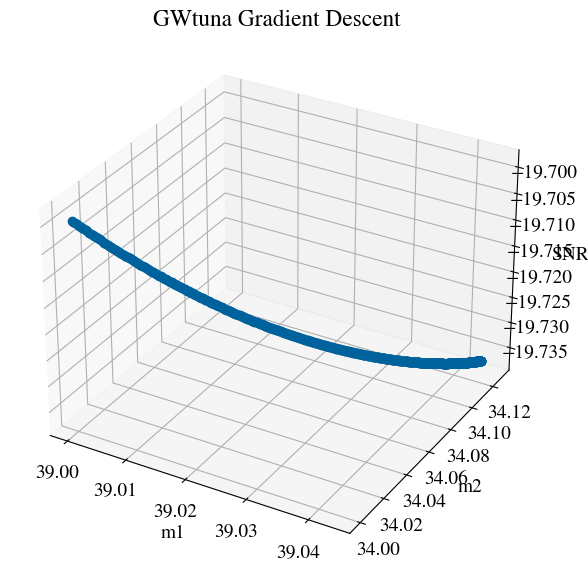

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["figure.autolayout"] = True

from mpl_toolkits.mplot3d import Axes3D

# Setting up Data Set for Animation
dataSet = np.array([mass1_list, mass2_list, snr_list])  # Combining our position coordinates
numDataPoints = len(mass1_list)

def animate_func(num):
    ax.clear()  # Clears the figure to update the line, point,   
                # title, and axes
    # Updating Trajectory Line (num+1 due to Python indexing)
    ax.plot3D(dataSet[0, :num+1], dataSet[1, :num+1], 
              dataSet[2, :num+1], c='#00629d',  marker='o', linestyle='None')
    # Updating Point Location 
    ax.scatter(dataSet[0, num], dataSet[1, num], dataSet[2, num], 
               c='#00629d', marker='o')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # Adding Constant Origin
    #ax.plot3D(dataSet[0, 0], dataSet[1, 0], dataSet[2, 0],     
    #           c='black', marker='o')
    # Setting Axes Limits
    #ax.set_xlim3d([0, 100])
    #ax.set_ylim3d([0, 100])
    #ax.set_zlim3d([0, 12])

    # Adding Figure Labels
    ax.set_title('GWtuna Gradient Descent')
    ax.set_xlabel('m1')
    ax.set_ylabel('m2')
    ax.set_zlabel('SNR')

# Plotting the Animation
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = plt.axes(projection='3d')
line_ani = animation.FuncAnimation(fig, animate_func, interval=100,   
                                   frames=numDataPoints)

# save the animation as mp4 video file 
line_ani.save('MassAnimation.gif', writer='imagemagick') 
plt.show()